In [183]:
import cProfile
import re
import scipy

import numpy as np
import random


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numba

In [184]:
cd C:\Users\ArianStolk\Documents\GitHub\SPDC


C:\Users\ArianStolk\Documents\GitHub\SPDC


In [185]:
%run main.py
%run physics.py

In [186]:
kk=2

Crystal1=Crystal(name = 'BBO1',material = 'BBO',position = [0,0,2.5],thickness = 5,orientation="up",cutangle=28.76*np.pi/180)
ACH=Lens.asphere(position = [0,0,60],centre=[-0.6,0,0],f= 50)
Csetup=ExpSetup(Crystal1,ACH)
sim=Simulation(rays=[0],setup=Csetup,store_path=True,store_time=True)
sim.run(Ntot=4000000,nr_crystals=1,gen_SPDC = True,pumpray=Ray(position=[0,0,0],angles=[0,0],wavelength=405,polarization="H"),pump_waist=[[0.33*0.098334,0.096517*0.33],[0.33*0.096551,0.052454*0.33],[0.081456*0.33,0.025478*0.33]][kk],pump_focus=[8,8],l_min=650,theta_min=-2*np.pi/180,theta_max=2*np.pi/180,cutangle=28.76*np.pi/180,pumpcurv=False)
SPDC_list=sim.start_list
print(len(sim.complete_results[0][0]))

vis2=Visualization(simulation=sim)
rays_end = 5.0001
vis2.interpol_data(pos=rays_end)
downdown_start_list= vis2.dummy_surface



14681


In [175]:
rays_end = 5.0001
fibre_diam = 0.025
fibre_NA = 0.22

def get_results_evol(visualization,x):
    visualization.filter_results(fibre_pos=x,core_diam = fibre_diam ,Num_Ap=fibre_NA)
    Hit_Lens_True=((visualization.complete_results[0][0][...,2][...,0:2]-np.array([-0.18,0]))*(visualization.complete_results[0][0][...,2][...,0:2]-np.array([-0.18,0]))).sum(axis=1)<(3.5**2)/4
    
    dummy_new=[[[] for _ in range(5)] for _ in range(2)]
    for i,dummy_list in enumerate(visualization.dummy_surface):
        for j,attr in enumerate(dummy_list[0:-2]):

            dummy_new[i][j]=attr[Hit_Lens_True]

                
    visualization.dummy_surface=dummy_new  
   
    visualization.filter_results(fibre_pos=x,core_diam = fibre_diam ,Num_Ap=fibre_NA)
    coinc=len(visualization.coincidences[0][0])
    signal_e=(coinc)/(len(visualization.singles[1][0])+1)
    idler_e=(coinc)/(len(visualization.singles[0][0])+1)
    print("final coinc are",coinc)
    spectrum=np.histogram(np.concatenate((visualization.singles[0][2],visualization.singles[1][2])),np.linspace(600,1100,100))
    return [coinc,signal_e,idler_e,spectrum]

def focus_setup(y,sbeg,send,ibeg,iend,z_beg,z_end,offset=0):
    returnlist=[]
    pos=offset+y

    scale=((pos-z_beg)/(z_end-z_beg))
#     scale=((pos-z_beg)/(z_end-z_beg))[0]
    
    signal=sbeg+(send-sbeg)*scale
    idler=ibeg+(iend-ibeg)*scale

    spot_sig=np.histogram2d(signal[:,0],signal[:,1],[np.linspace(-0.4,-0.0,200),np.linspace(-0.2,0.2,50)])[0]
    spot_idl=np.histogram2d(idler[:,0],idler[:,1],[np.linspace(-0.4,-0.0,200),np.linspace(-0.2,0.2,50)])[0]
    
    comb_spot=(spot_sig+spot_idl)
    
    return np.max(comb_spot)

In [7]:
Optimize = False
pumpcurvl = [True,True,True,True,True]
walkoffl = [True,True,True,True,True]
# ############################Horizontal SHRINKING####################################################
# pump_M2_list=np.array([[1.0577,1.1076],[1.4723,1.0191],[1.6733,1],[1.1,1.0]])*1
# pumps = [[0.098334,0.096517],[0.096551,0.052454],[0.081456,0.025478],[0.099,0.137]]
# pump_focus_list=[[2.5+11.9,2.5],[2.5-8,2.5],[2.5-22.8,2.5],[2.5-48,2.5]]

# ############################VERTICAL SHRINKING#######################################################
# pump_M2_list=np.array([[1.0577,1.1076],[1.22,1.08],[1.,1],[1.1,1.0]])*1
# pumps = np.array([[0.098334,0.096517],[0.0521,0.096],[0.0325,0.0956],[0.1485,0.099]])
# pump_focus_list=np.array([[2.5+11.9,2.5],[2.5,2.5+23],[2.5,2.5-10.5],[2.5,2.5-34.5]])

############################WISHFULL THINKING#####################################################
pump_M2_list=np.array([[1.0577,1.1076],[1.4723,1.0191],[1.6733,1]])*1
pumps = [[0.099,0.137*0.33],[0.098334,0.096517*0.33],[0.096551,0.052454*0.33],[0.081456,0.025478*0.33]]
pump_focus_list=[[2.5+11.9,2.5],[2.5-8,2.5],[2.5-22.8,2.5]]
#                     [[-3,-3],[3,3],[22.5,0]]
###################################################################################################

lensd_photons_1=[[[] for x in range(len([3,4,5,6,7,8,9,10,11,12,13,14,15]))]for y in pumps]
lensd_fibre_1=[[[] for x in range(len([3,4,5,6,7,8,9,10,11,12,13,14,15]))]for y in pumps]

for k in range(1):
    pumpcurv=pumpcurvl[k]
    walkoff=walkoffl[k]
    for i,pump in enumerate(pumps):
        pump=np.array(pump)
        print(pump)
        pump_focus=np.array(pump_focus_list[i])
        pump_M2 = pump_M2_list[i]
#     for i,pump in enumerate([[0.5,0.5]]):
        for j,holes in enumerate([3,4,5,6,7,8,9,10,11,12,13,14,15]):
#         for j,holes in enumerate([4,5]):
            Crystal1=Crystal(name = 'BBO1',material = 'BBO',position = [0,0,2.5],thickness = 5,orientation="up",cutangle=28.76*np.pi/180)
            lenspos=25*holes
    #         print(lenspos)
            ACH=Lens.asphere_r(position = [0,0,lenspos],centre=[-0.18,0,0],f=250)
            Csetup=ExpSetup(Crystal1,ACH)
            sim2=Simulation(rays=[0],setup=Csetup)
            sim2.run(Ntot=300000,nr_crystals=1,gen_SPDC = True,pumpray=Ray(position=[0,0,0],angles=[0,0],wavelength=405,polarization="H"),pump_waist=pump,pump_focus=pump_focus,pump_M2=pump_M2,walkoff=walkoff,pumpcurv=pumpcurv)
            print(len(sim2.complete_results[0][0]))
            vis2=Visualization(simulation=sim2)
#             plt.figure()
#             plt.hist(90/np.pi*((vis2.simulation.start_list[0][1]).T[0]+(vis2.simulation.start_list[1][1]).T[0]),alpha=0.5)
#             plt.hist(90/np.pi*((vis2.simulation.start_list[0][1]).T[1]+(vis2.simulation.start_list[1][1]).T[1]),alpha=0.5)
#             plt.show()
    #         vis2.showpos_single(pos=5.001)
    #         vis2.SPDC_list=SPDC_list
            Hit_Lens_True=((vis2.complete_results[0][0][...,2][...,0:2]-np.array([-0.18,0]))*(vis2.complete_results[0][0][...,2][...,0:2]-np.array([-0.18,0]))).sum(axis=1)<(3.5**2)/4

            send=np.float32(vis2.complete_results[0][0][...,-1][...,0:2])[Hit_Lens_True]
            sbeg=np.float32(vis2.complete_results[0][0][...,-2][...,0:2])[Hit_Lens_True]

            iend=np.float32(vis2.complete_results[1][0][...,-1][...,0:2])[Hit_Lens_True]
            ibeg=np.float32(vis2.complete_results[1][0][...,-2][...,0:2])[Hit_Lens_True]

            z_beg_val=np.float32(vis2.complete_results[0][0][...,-2][0][...,2])
            z_end_val=np.float32(vis2.complete_results[0][0][...,-1][0][...,2])


            [sbeg,send,ibeg,iend]=Visualization.select_NA_TRUE(sbeg,send,ibeg,iend,z_beg_val,z_end_val,core_diam=0.025,Num_Ap=0.22)
            
            
#             plt.plot(np.linspace(8,11,500),[focus_setup(x,sbeg,send,ibeg,iend,z_beg_val,z_end_val,offset=lenspos) for x in np.linspace(8,11,500)])
#             plt.title("pump is {} and lensd is {}".format(pump,lenspos))
#             plt.show()

#             [(vis2.showpos_single(pos = x+lenspos),print(focus_setup(x+lenspos,sbeg,send,ibeg,iend,z_beg_val,z_end_val))) for x in np.linspace(15,21,25)]

    #         print(np.min([vis2.showpos_single(pos=x+lenspos) for x in np.linspace(0,100,100)]))
            
            scanlist=[focus_setup(x,sbeg,send,ibeg,iend,z_beg_val,z_end_val,lenspos) for x in np.linspace(8,11,500)]
            result_for_foc=[np.max(scanlist),np.linspace(8,11,500)[np.argmax(scanlist)]]
            print(result_for_foc[0],result_for_foc[1])
            search_pos=[-0.18,0,result_for_foc[1]+lenspos]
            if Optimize:
                dx=0.1
                dy=0.05
                dz=0.2
                res=np.empty((20,20,250))
                scale=1
                scale_evol=0.75
                coinc_start= 0
                coincs= 0
                been_0=False
                while dz>0.00005 and dz<10 :

                        print(dx,dy,dz,search_pos)

                        x_range=np.linspace(search_pos[0]-dx,search_pos[0]+dx,20,dtype=np.float32)
                        y_range=np.linspace(search_pos[1]-dy,search_pos[1]+dy,20,dtype=np.float32)
                        z_range=np.linspace(search_pos[2]-dz,search_pos[2]+dz,250,dtype=np.float32)

                        res=d_coinc(sbeg, send ,ibeg,iend,x_range,y_range,(z_range-z_beg_val)/(z_end_val-z_beg_val))
                        coincs=np.max(res)
                        maxindex=np.unravel_index(np.argmax(res),res.shape)


                        if coincs < 2:
                            dx *= 1.
                            dy *= 1.
                            dz *= 1.1
                            search_pos[2]+=0.01
                            been_0 =True
#                             if not coincs == 0: 
#                                 search_pos[2] = z_range[maxindex[2]]
                            dx = max(0.2,dx)
                            dy = max(0.05,dy)


                        else:
                            if been_0:
                                dx=0.1
                                dy=0.02
                                dz=0.1
                                been_0 = False

                            scale *=scale_evol 
                            dx *= scale*(0.66+2*((abs(maxindex[0]-10))/20))
                            dy *= scale*(0.66+2*((abs(maxindex[1]-10))/20))
                            dz *= scale*(0.66+2*((abs(maxindex[2]-125))/250))

    #                         dx *= 2/100
    #                         dy *= 2/60
    #                         dz *= 2/100

                            search_pos = [x_range[maxindex[0]],y_range[maxindex[1]],z_range[maxindex[2]]]
                        diff=abs(coinc_start-coincs)
                        coinc_start=coincs
                        print("coincidences are",coincs,maxindex)

    #         vis2.showpos_single(pos=search_pos[-1])
            print(search_pos)
            lensd_fibre_1[i][j]=search_pos
            del sim2.start_list
            sim2.interpol_pos = 0
#             print(hasattr(sim2,'start_list'))
            sim2.run(Ntot=30000000,nr_crystals=1,gen_SPDC = True,pumpray=Ray(position=[0,0,0],angles=[0,0],wavelength=405,polarization="H"),pump_waist=pump,pump_focus=pump_focus,pump_M2=pump_M2,walkoff=walkoff,pumpcurv=pumpcurv)
            vis_result=Visualization(simulation=sim2)

    #         vis_result.showpos_single(pos=search_pos[-1])


            lensd_photons_1[i][j]+=get_results_evol(vis_result,search_pos)
    print("doing iteration {}".format(k+1))



            
        



[ 0.099    0.04521]
1146
82.0 9.64729458918
[-0.18, 0, 84.647294589178358]
final coinc are 37520
1143
142.0 9.31062124248
[-0.18, 0, 109.31062124248497]


C:\Users\ArianStolk\Documents\GitHub\SPDC\main.py:587: RuntimeWarning: invalid value encountered in arcsin
  angles =  np.arcsin(np.sin(angle)*indexfract)+np.arctan(position_on_lens*(alpha/np.cos(alpha)))
C:\Users\ArianStolk\Documents\GitHub\SPDC\main.py:386: RuntimeWarning: invalid value encountered in less
  core_dist_check=((pos-fibre_pos)*(pos-fibre_pos)).sum(axis=1)<(core_diam/2)**2
C:\Users\ArianStolk\Documents\GitHub\SPDC\main.py:387: RuntimeWarning: invalid value encountered in less
  inc_angle_check=(angle*angle).sum(axis=1)<Num_Ap**2


final coinc are 35106
1099
245.0 9.14228456914
[-0.18, 0, 134.14228456913827]
final coinc are 28500
1172
279.0 9.04008016032
[-0.18, 0, 159.04008016032066]
final coinc are 24081
1152
173.0 9.00400801603
[-0.18, 0, 184.00400801603206]
final coinc are 23822
1137
101.0 8.9498997996
[-0.18, 0, 208.94989979959919]
final coinc are 20730
1089
80.0 8.92585170341
[-0.18, 0, 233.92585170340681]
final coinc are 19206
1099
72.0 8.88376753507
[-0.18, 0, 258.88376753507015]
final coinc are 16506
1046
51.0 8.82364729459
[-0.18, 0, 283.82364729458919]
final coinc are 12750
1146
50.0 8.82965931864
[-0.18, 0, 308.82965931863725]
final coinc are 13373
1042
45.0 8.83567134269
[-0.18, 0, 333.83567134268537]
final coinc are 13075
1086
49.0 8.78156312625
[-0.18, 0, 358.78156312625248]
final coinc are 10617
1131
37.0 8.7875751503
[-0.18, 0, 383.7875751503006]
final coinc are 10574
[ 0.098334    0.03185061]
1167
105.0 9.59919839679
[-0.18, 0, 84.599198396793582]
final coinc are 35430
1082
132.0 9.32264529058
[

IndexError: list index out of range

In [ ]:
Optimize = True
pumpcurvl = [True,True,True,True,True]
walkoffl = [True,True,True,True,True]

pump_M2_list=np.array([[1.0577,1.1076],[1.4723,1.0191],[1.6733,1]])*1
pumps = [[0.098334,0.096517],[0.052,0.096],[0.032,0.096]]
pump_focus_list=[[2.5+11.9,2.5],[2.5,2.5-23],[2.5,2.5-10]]

lensd_photons_2=[[[] for x in range(len([3,4,5,6,7,8,9,10,11,12,13,14,15]))]for y in pumps]
lensd_fibre_2=[[[] for x in range(len([3,4,5,6,7,8,9,10,11,12,13,14,15]))]for y in pumps]

for k in range(5):
    pumpcurv=pumpcurvl[k]
    walkoff=walkoffl[k]
    for i,pump in enumerate(pumps):
        pump=np.array(pump)
        print(pump)
        pump_focus=np.array(pump_focus_list[i])
        pump_M2 = pump_M2_list[i]
    # for i,pump in enumerate([[0.5,0.5]]):
        for j,holes in enumerate([3,4,5,6,7,8,9,10,11,12,13,14,15]):
#         for j,holes in enumerate([4,5]):
            Crystal1=Crystal(name = 'BBO1',material = 'BBO',position = [0,0,2.5],thickness = 5,orientation="up",cutangle=28.76*np.pi/180)
            lenspos=25*holes
    #         print(lenspos)
            ACH=Lens.achromat_aitor_r(position = [0,0,lenspos],centre=[-0.18,0,0],f=250)
            Csetup=ExpSetup(Crystal1,ACH)
            sim2=Simulation(rays=[0],setup=Csetup)
            sim2.run(Ntot=90000000,nr_crystals=1,gen_SPDC = True,pumpray=Ray(position=[0,0,0],angles=[0,0],wavelength=405,polarization="H"),pump_waist=pump,pump_focus=pump_focus,pump_M2=pump_M2,walkoff=walkoff,pumpcurv=pumpcurv)
            print(len(sim2.complete_results[0][0]))
            vis2=Visualization(simulation=sim2)
#             plt.figure()
#             plt.hist(90/np.pi*((vis2.simulation.start_list[0][1]).T[0]+(vis2.simulation.start_list[1][1]).T[0]),alpha=0.5)
#             plt.hist(90/np.pi*((vis2.simulation.start_list[0][1]).T[1]+(vis2.simulation.start_list[1][1]).T[1]),alpha=0.5)
#             plt.show()
    #         vis2.showpos_single(pos=5.001)
    #         vis2.SPDC_list=SPDC_list
            Hit_Lens_True=((vis2.complete_results[0][0][...,2][...,0:2]-np.array([-0.18,0]))*(vis2.complete_results[0][0][...,2][...,0:2]-np.array([-0.18,0]))).sum(axis=1)<(7.5**2)/4

            send=np.float32(vis2.complete_results[0][0][...,-1][...,0:2])[Hit_Lens_True]
            sbeg=np.float32(vis2.complete_results[0][0][...,-2][...,0:2])[Hit_Lens_True]

            iend=np.float32(vis2.complete_results[1][0][...,-1][...,0:2])[Hit_Lens_True]
            ibeg=np.float32(vis2.complete_results[1][0][...,-2][...,0:2])[Hit_Lens_True]

            z_beg_val=np.float32(vis2.complete_results[0][0][...,-2][0][...,2])
            z_end_val=np.float32(vis2.complete_results[0][0][...,-1][0][...,2])

            print(send.shape)

            [sbeg,send,ibeg,iend]=Visualization.select_NA_TRUE(sbeg,send,ibeg,iend,z_beg_val,z_end_val)

#             plt.plot(np.linspace(18,21,500),[focus_setup(x,sbeg,send,ibeg,iend,z_beg_val,z_end_val,offset=lenspos) for x in np.linspace(18,21,500)])
#             plt.title("pump is {} and lensd is {}".format(pump,lenspos))
#             plt.show()

#             [(vis2.showpos_single(pos = x+lenspos),print(focus_setup(x+lenspos,sbeg,send,ibeg,iend,z_beg_val,z_end_val))) for x in np.linspace(15,21,25)]

    #         print(np.min([vis2.showpos_single(pos=x+lenspos) for x in np.linspace(0,100,100)]))
            if Optimize:
                scanlist=[focus_setup(x,sbeg,send,ibeg,iend,z_beg_val,z_end_val,lenspos) for x in np.linspace(18,21,500)]
                result_for_foc=[np.max(scanlist),np.linspace(18,21,500)[np.argmax(scanlist)]]
                print(result_for_foc[0],result_for_foc[1])
                search_pos=[-0.18,0,result_for_foc[1]+lenspos]

                dx=0.05
                dy=0.025
                dz=0.1
                res=np.empty((20,20,100))
                scale=1
                scale_evol=0.75
                coinc_start= 0
                coincs= 0
                been_0=False
                while dz>0.0005 and dz<10 :

                        print(dx,dy,dz,search_pos)

                        x_range=np.linspace(search_pos[0]-dx,search_pos[0]+dx,20,dtype=np.float32)
                        y_range=np.linspace(search_pos[1]-dy,search_pos[1]+dy,20,dtype=np.float32)
                        z_range=np.linspace(search_pos[2]-dz,search_pos[2]+dz,100,dtype=np.float32)

                        res=d_coinc(sbeg, send ,ibeg,iend,x_range,y_range,(z_range-z_beg_val)/(z_end_val-z_beg_val))
                        coincs=np.max(res)
                        maxindex=np.unravel_index(np.argmax(res),res.shape)


                        if coincs < 1:
                            dx *= 1.
                            dy *= 1.
                            dz *= 1.1
                            search_pos[2]+=0.01
                            been_0 =True
#                             if not coincs == 0: 
#                                 search_pos[2] = z_range[maxindex[2]]
                            dx = max(0.2,dx)
                            dy = max(0.05,dy)


                        else:
                            if been_0:
                                dx=0.1
                                dy=0.02
                                dz=0.1
                                been_0 = False

                            scale *=scale_evol 
                            dx *= scale*(0.66+2*((abs(maxindex[0]-10))/20))
                            dy *= scale*(0.66+2*((abs(maxindex[1]-10))/20))
                            dz *= scale*(0.66+2*((abs(maxindex[2]-50))/100))

    #                         dx *= 2/100
    #                         dy *= 2/60
    #                         dz *= 2/100

                            search_pos = [x_range[maxindex[0]],y_range[maxindex[1]],z_range[maxindex[2]]]
                        diff=abs(coinc_start-coincs)
                        coinc_start=coincs
                        print("coincidences are",coincs,maxindex)

    #         vis2.showpos_single(pos=search_pos[-1])
            print(search_pos)
            lensd_fibre_2[i][j]=search_pos
            del sim2.start_list
            sim2.interpol_pos = 0
#             print(hasattr(sim2,'start_list'))
            sim2.run(Ntot=240000000,nr_crystals=1,gen_SPDC = True,pumpray=Ray(position=[0,0,0],angles=[0,0],wavelength=405,polarization="H"),pump_waist=pump,pump_focus=pump_focus,pump_M2=pump_M2,walkoff=walkoff,pumpcurv=pumpcurv)
            vis_result=Visualization(simulation=sim2)

    #         vis_result.showpos_single(pos=search_pos[-1])


            lensd_photons_2[i][j]+=get_results_evol(vis_result,search_pos)
    print("doing iteration {}".format(k+1))


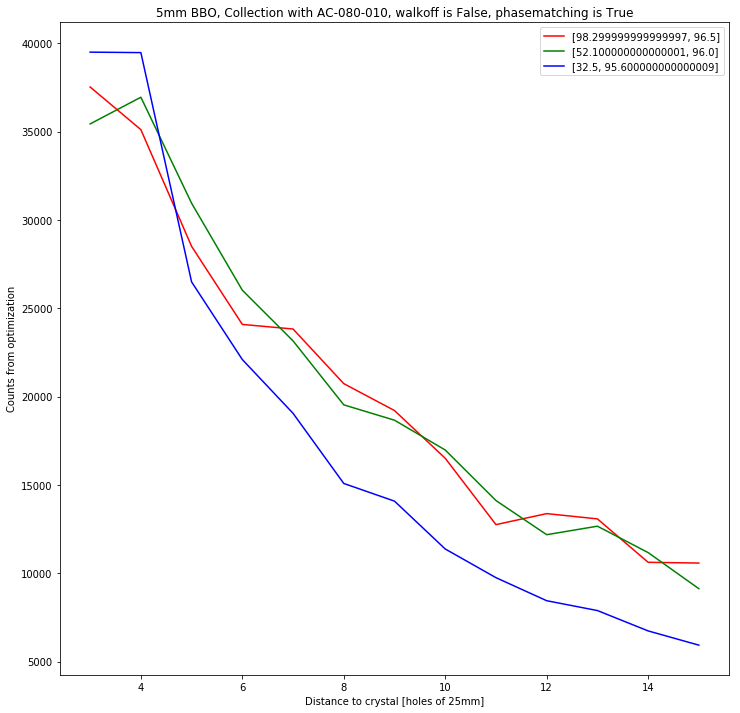

In [13]:

pumps = np.array([[0.098334,0.096517],[0.0521,0.096],[0.0325,0.0956],[0.099,0.1485]])


xpos=[3,4,5,6,7,8,9,10,11,12,13,14,15]

plt.figure(figsize=[12,12])
for y in [0,1,2]:
    c = ['r-','g-','b-','y-','k-','y-.','b-.','g-.','r-.'][y]
    label = [1000*round(pumps[y][0],4),1000*round(pumps[y][1],4)]
    plt.plot(xpos,[max([(lensd_photons_1[y][i][kk*4]) for kk in range(1)]) for i,x in enumerate(xpos)],c,label=label)
plt.title("5mm BBO, Collection with AC-080-010, walkoff is {}, phasematching is {}".format([True,True,False,False][kk],[True,False,True,False][kk]))
plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()

In [10]:
rawdata=[[],[],[],[],[]]

pump_M2_list=np.array([[1.0577,1.1076],[1.22,1.08],[1.,1],[1.1,1.0]])*1
pumps = np.array([[0.098334,0.096517],[0.0521,0.096],[0.0325,0.0956],[0.099,0.1485]])
pump_focus_list=np.array([[2.5+11.9,2.5],[2.5,2.5+23],[2.5,2.5-10.5],[2.5,2.5-34.5]])

for y in [0,1,2,3]:

    rawdata[y+1]=[max([(lensd_photons_1[y][i][kk*4]) for kk in range(5)]) for i,x in enumerate(xpos)]
    
rawdata[0]=xpos
np.savez("C:/Users/ArianStolk/Documents/13012017_horizontal_ellipse",rawdata,pumps,pump_focus_list,pump_M2_list)

In [22]:
imported=np.load("C:/Users/ArianStolk/Documents/22122017_vertical_ellipse.npz")

imported['arr_2']

array([[ 14.4,   2.5],
       [ -5.5,   2.5],
       [-20.3,   2.5],
       [-45.5,   2.5]])

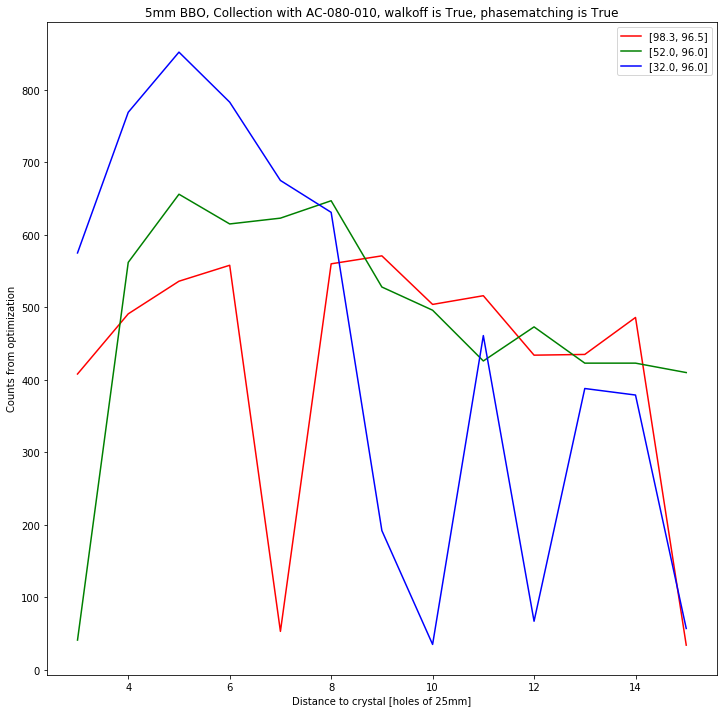

In [24]:
xpos=[3,4,5,6,7,8,9,10,11,12,13,14,15]
pumps = [[0.098334,0.096517],[0.052,0.096],[0.032,0.096]]
kk=0

plt.figure(figsize=[12,12])
for y in [0,1,2]:
    c = ['r-','g-','b-','y-','k-','y-.','b-.','g-.','r-.'][y]
    label = [1000*round(pumps[y][0],4),1000*round(pumps[y][1],4)]
    plt.plot(xpos,[(lensd_photons_2[y][i][kk*4]) for i,x in enumerate(xpos)],c,label=label)
plt.title("5mm BBO, Collection with AC-080-010, walkoff is {}, phasematching is {}".format([True,True,False,False][kk],[True,False,True,False][kk]))
plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()

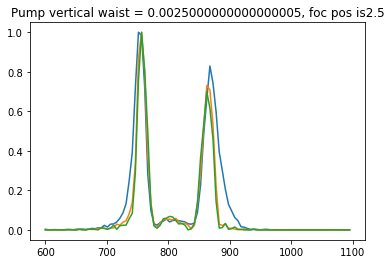

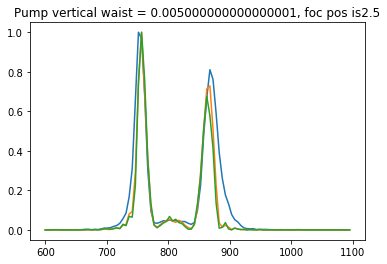

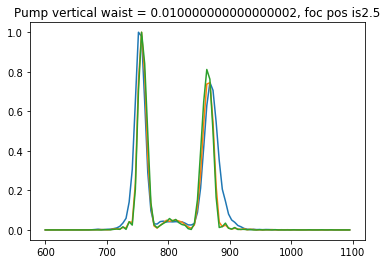

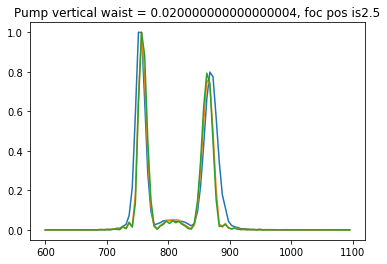

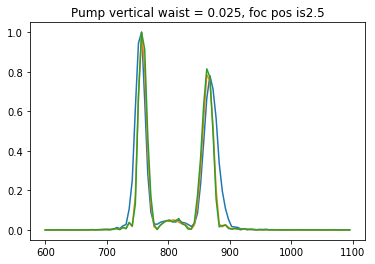

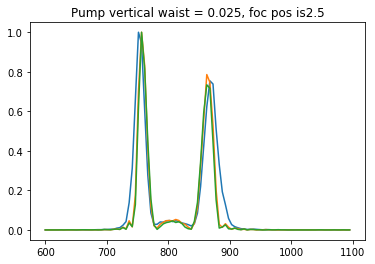

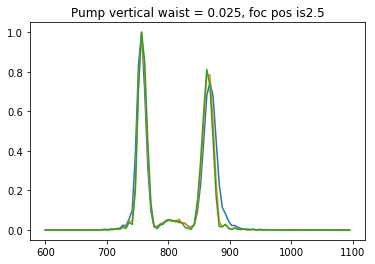

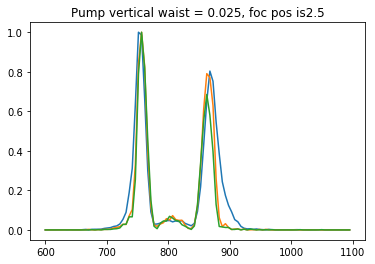

In [51]:
kk=12
for y in range(8):
    plt.figure()
    [plt.plot(lensd_photons_ast[y][x][3+kk][1][0:-1],lensd_photons_ast[y][x][3+kk][0]/max(lensd_photons_ast[y][x][3+kk][0])) for x in [0,5,-1]]
    plt.title("Pump vertical waist = {}, foc pos is{}".format(pumps[y][0],pump_focus_list[y][0]))
    plt.show()

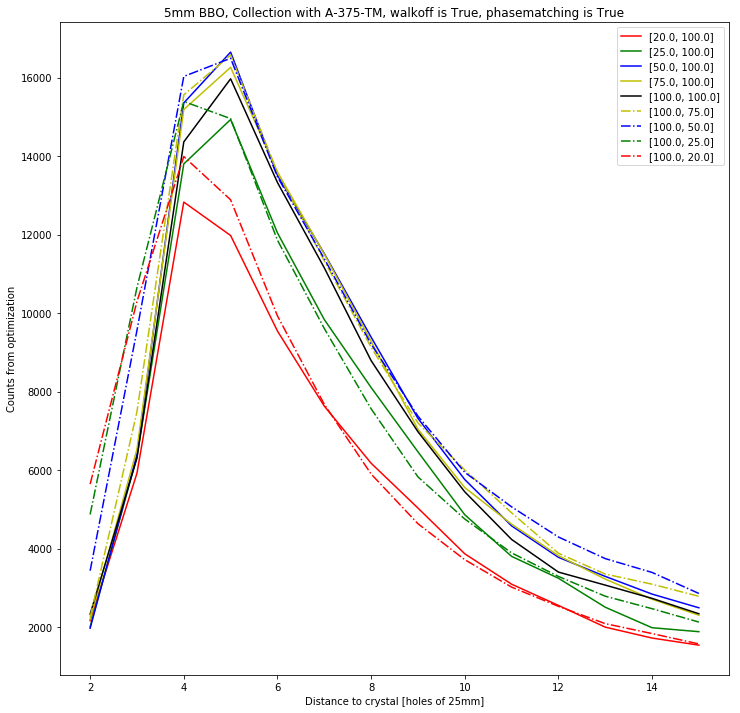

In [16]:
xpos=[2,3,4,5,6,7,8,9,10,11,12,13,14,15]
kk=0

plt.figure(figsize=[12,12])
for y in [0,1,2,3,4,5,6,7,8]:
    c = ['r-','g-','b-','y-','k-','y-.','b-.','g-.','r-.'][y]
    label = [1000*round(pumps[y][0],4),1000*round(pumps[y][1],4)]
    plt.plot(xpos,[(lensd_photons_asph[y][i][kk*4]) for i,x in enumerate(xpos)],c,label=label)
plt.title("5mm BBO, Collection with A-375-TM, walkoff is {}, phasematching is {}".format([True,True,False,False][kk],[True,False,True,False][kk]))
plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()

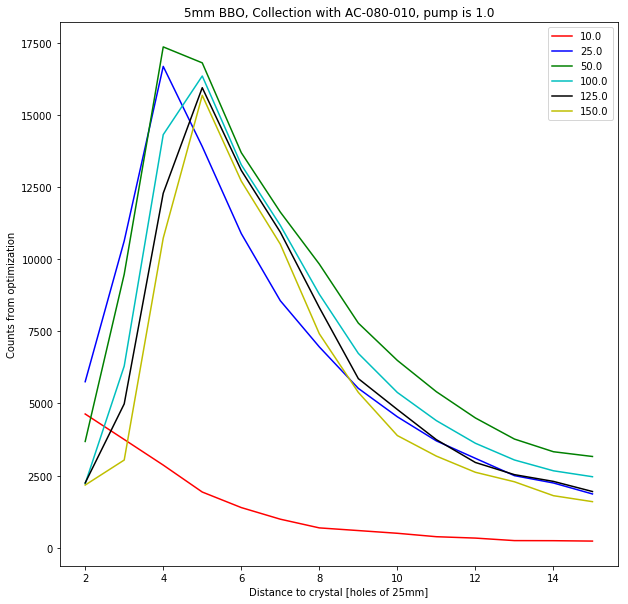

In [8]:
xpos=[2,3,4,5,6,7,8,9,10,11,12,13,14,15]
kk=0

plt.figure(figsize=[10,10])
for y in [0,1,2,3,4,5]:
    c = ['r-','b-','g-','c-','k-','y-','m-'][y]
    label = 1000*round(pumps_circ[y][1],3)
    plt.plot(xpos,[(lensd_photons_circ_asph[y][i][kk]) for i,x in enumerate(xpos)],c,label=label)
plt.title("5mm BBO, Collection with A-375-TMB, pump is {}".format(pumps_circ[y][1]/pumps_circ[y][0]))
plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()

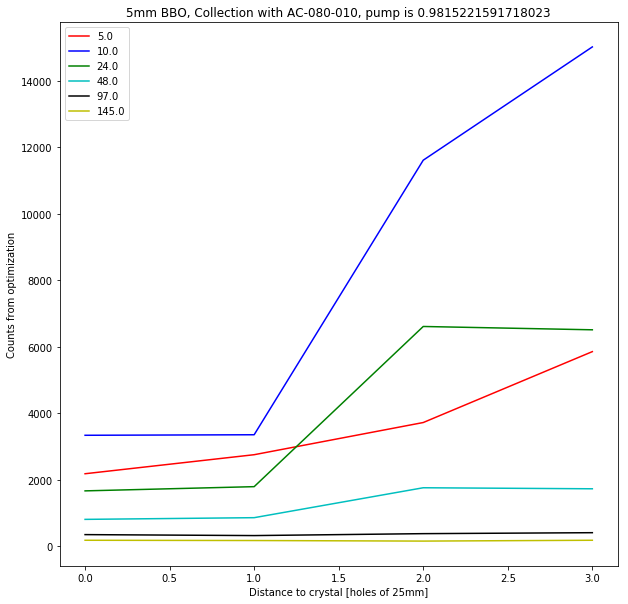

In [42]:
xpos=0
plt.figure(figsize=[10,10]) 
for y in [0,1,2,3,4,5]: 
    c = ['r-','b-','g-','c-','k-','y-','m-'][y] 
    label = 1000*round(pumps[y][1],3)
    plt.plot(range(4),[(lensd_photons[y][xpos][kk*4]) for kk in range(4)],c,label=label) 
    plt.title("5mm BBO, Collection with AC-080-010, pump is {}".format(pumps[y][1]/pumps[y][0])) 
    plt.xlabel("Distance to crystal [holes of 25mm]") 
    plt.ylabel("Counts from optimization") 
plt.legend() 
plt.show()

In [55]:
np.savez("C:/Users/ArianStolk/Documents/ast_sweep_10122017_result_circsym_sweep",lensd_photons)
# np.savez("C:/Users/ArianStolk/Documents/ast_sweep_10122017_coos_circsym_sweep",np.reshape(lensd_fibre,(6,len([4,5,6,7,8,9,10,11,12,13,14,15]),3)))
# np.savez("C:/Users/ArianStolk/Documents/ast_sweep_10122017_pumps_circsym_sweep",np.reshape(pumps,(6,2)))

ValueError: setting an array element with a sequence.

In [60]:
lensd_photons[0][0]

[2175,
 0.5867278122471001,
 0.7430816535702084,
 (array([  3,   3,   0,   0,   2,   2,   1,   0,   3,   4,   4,   4,   5,
          15,   6,  13,  20,  17,  20,  28,  32,  45,  55,  53,  88,  79,
         106, 119, 155, 167, 191, 212, 197, 175, 167, 150, 146, 139, 144,
         129, 136, 142, 132, 120, 128, 150, 123, 140, 148, 154, 160, 162,
         181, 188, 199, 175, 154, 151, 119, 124, 107,  87,  64,  80,  47,
          58,  47,  50,  42,  47,  37,  30,  26,  17,  20,  20,  21,  21,
           9,  19,  11,   6,   8,  11,   7,  10,   2,   4,  10,   3,   2,
           5,   3,   1,   0,   2,   1,   2,   0], dtype=int64),
  array([  600.        ,   605.05050505,   610.1010101 ,   615.15151515,
           620.2020202 ,   625.25252525,   630.3030303 ,   635.35353535,
           640.4040404 ,   645.45454545,   650.50505051,   655.55555556,
           660.60606061,   665.65656566,   670.70707071,   675.75757576,
           680.80808081,   685.85858586,   690.90909091,   695.95959596,
    

get_counts_evol([-0.6,0,151],0.1,0.22)

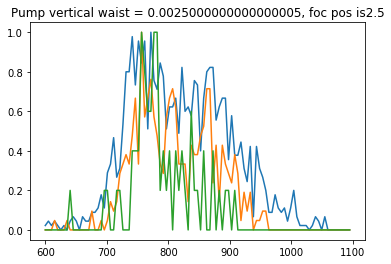

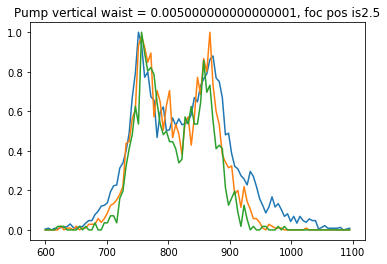

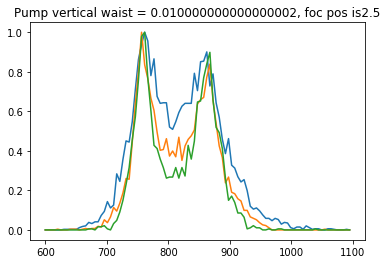

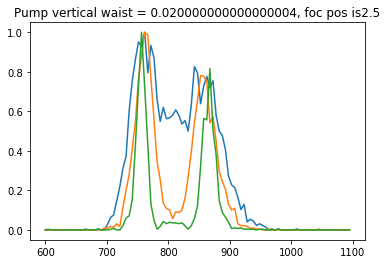

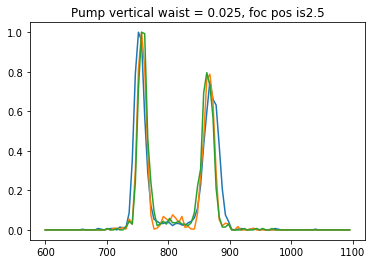

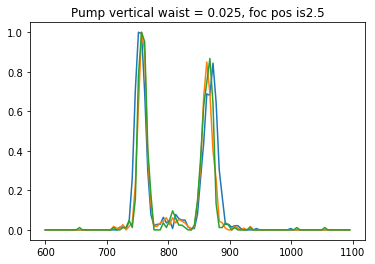

In [42]:
kk=0
for y in range(6):
    plt.figure()
    [plt.plot(lensd_photons[y][x][3+kk][1][0:-1],lensd_photons[y][x][3+kk][0]/max(lensd_photons[y][x][3+kk][0])) for x in [0,5,-1]]
    plt.title("Pump vertical waist = {}, foc pos is{}".format(pumps[y][0],pump_focus_list[y][0]))
    plt.show()

In [43]:
sum([lensd_photons[1][1][3+z][0] for z in [0,4,8]])

array([   0,    0,    0,    0,    1,    1,    0,    0,    0,    0,    1,
          0,    2,    1,    3,    7,    5,    4,    7,   15,   27,   23,
         95,  235,  489,  764,  944, 1121, 1275, 1624, 2091, 1969, 1291,
        701,  274,  105,   87,   88,  114,   90,  114,  109,   94,   91,
        106,   81,   72,   79,  109,  229,  528,  864, 1292, 1559, 1483,
       1230, 1007,  824,  783,  621,  587,  508,  443,  427,  316,  185,
         86,   59,   40,   25,   20,   10,   10,    3,    8,    4,    3,
          1,    2,    1,    4,    3,    2,    0,    4,    1,    0,    0,
          1,    0,    0,    1,    0,    0,    0,    0,    0,    0,    0], dtype=int64)

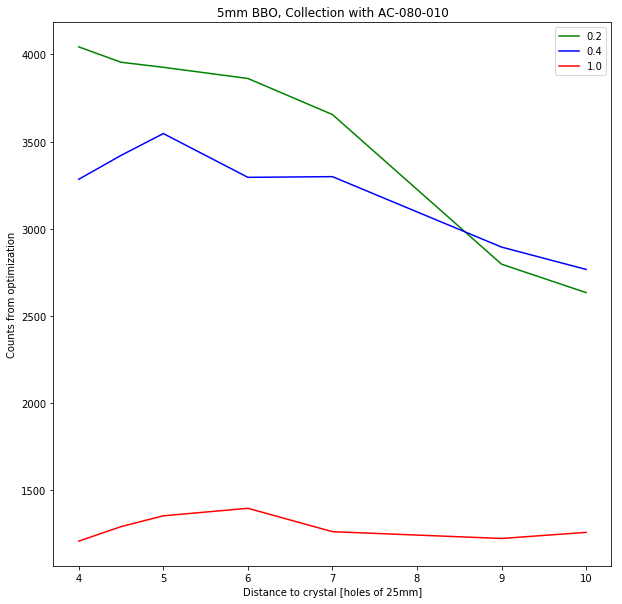

In [43]:
pumps = np.array([[121,28],[119,43],[120,79],[117,117],[78,116],[43,119],[28,121]])/1000
xpos=[4,4.5,5,6,7,9,10]

plt.figure(figsize=[10,10])
for y in [0,1,3]:
    c = ['g-','b-','b-','r-','k-','c-.','b-.','g-.'][y]
    label = [round(pump[1]/pump[0],1) for pump in pumps][y]
    plt.plot(xpos,[result_achromat[0][y][i+4] for i,x in enumerate(xpos)],c,label=label)

plt.title("5mm BBO, Collection with AC-080-010")
plt.xlabel("Distance to crystal [holes of 25mm]")
plt.ylabel("Counts from optimization")
plt.legend()
plt.show()

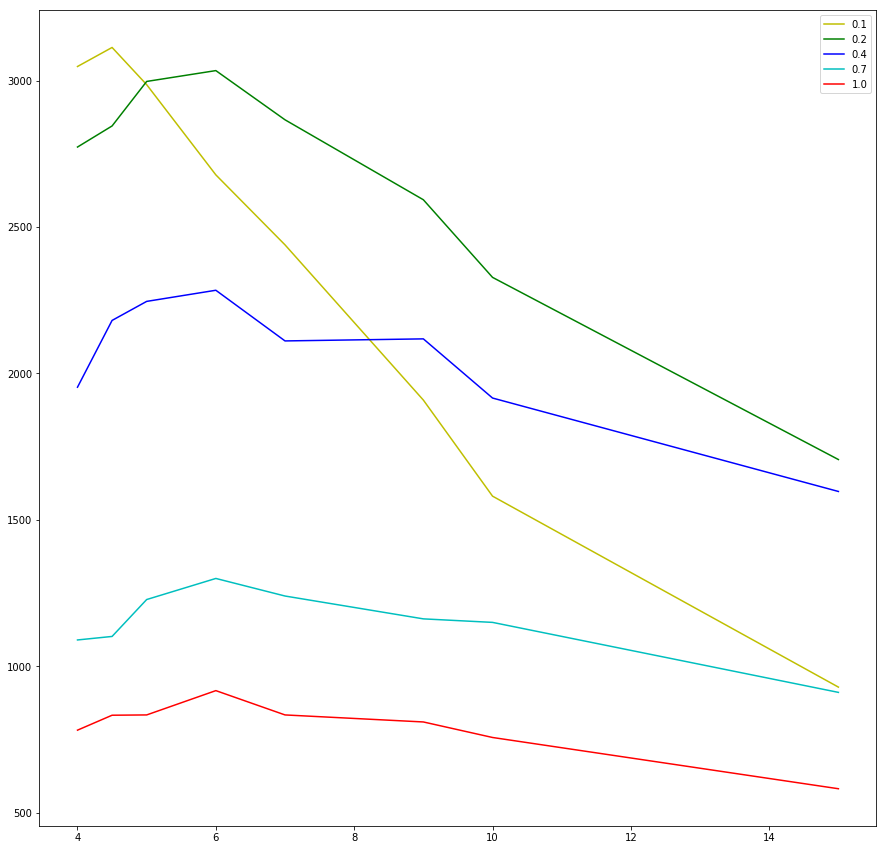

In [30]:
imported_data=np.load("C:/Users/ArianStolk/Documents/ast_sweep_28112017.npz")['arr_0']

plt.figure(figsize=[15,15])
for y in range(5):
    c = ['y-','g-','b-','c-','r-','c-.','b-.','g-.'][y]
    label = [round(pump[1]/pump[0],1) for pump in pumps][y]
    xpos=[4,4.5,5,6,7,9,10,15]
    plt.plot(xpos,[imported_data[0][y][i+4] for i,x in enumerate(xpos)],c,label=label)

plt.legend()
plt.show()

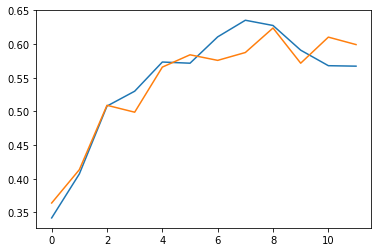

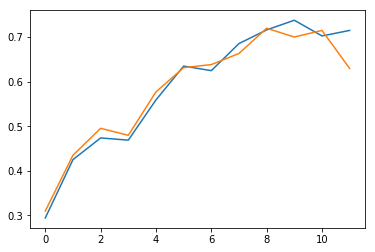

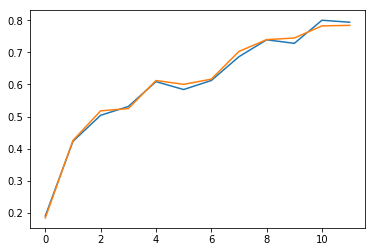

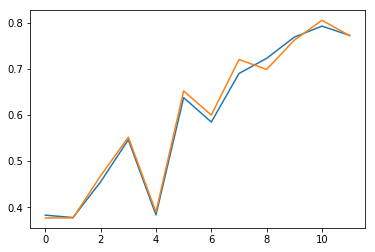

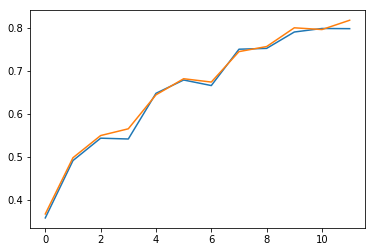

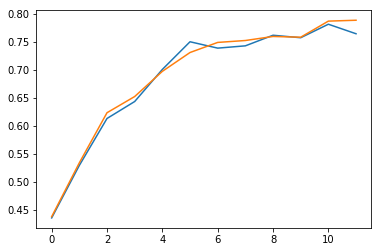

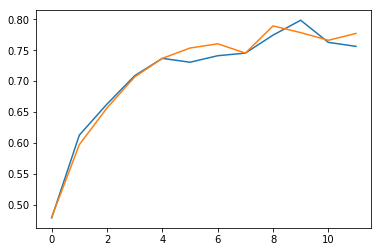

IndexError: list index out of range

In [38]:

for y in range(8):
    plt.figure()
    plt.plot([lensd_photons[y][x][1:3] for x in range(len([2,2.5,3,3.5,4,4.5,5,6,7,9,10,15]))])
    plt.show()


In [118]:
N=10000
M=50

send=np.float32(vis2.complete_results[0][0][...,-1][0:N][...,0:2])
sbeg=np.float32(vis2.complete_results[0][0][...,-2][0:N][...,0:2])

iend=np.float32(vis2.complete_results[1][0][...,-1][0:N][...,0:2])
ibeg=np.float32(vis2.complete_results[1][0][...,-2][0:N][...,0:2])

x,y,z=np.full(M,-0.2,dtype=np.float32),np.full(M,0,dtype=np.float32),np.full(M,61.375+25.,dtype=np.float32)

res=np.empty((M,M,M),dtype=np.float32)

In [119]:

cProfile.run('res=d_coinc(sbeg,send,ibeg,iend,x,y,z)',sort="time")

         3 function calls in 3.869 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    3.869    3.869    3.869    3.869 <string>:1(<module>)
        1    0.000    0.000    3.869    3.869 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




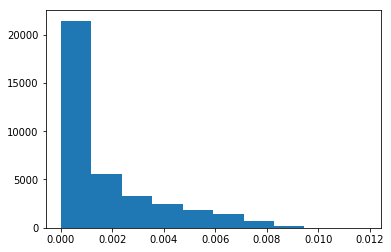

(array([    0,     1,     2, ..., 36958, 36959, 36960], dtype=int64),)

In [59]:
((vis2.complete_results[0][0][...,1][...,0:2]-np.array([-0.16,0]))*(vis2.complete_results[0][0][...,1][...,0:2]-np.array([-0.16,0]))).sum(axis=1)<4*4

array([False, False, False, ..., False,  True,  True], dtype=bool)

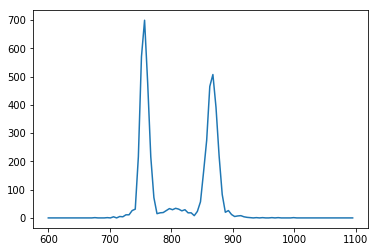

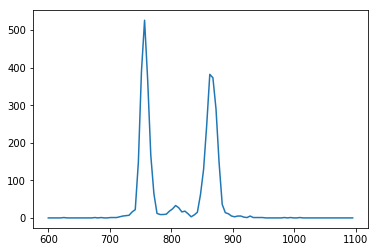

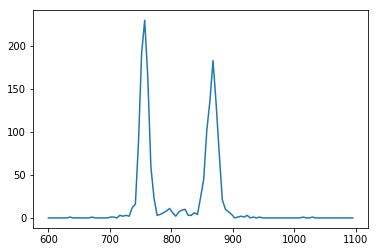

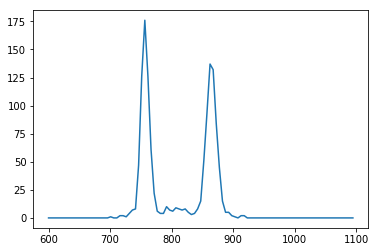

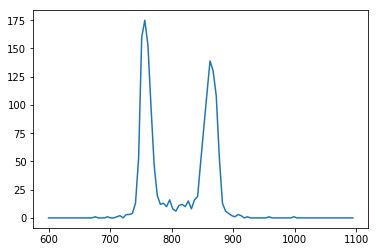

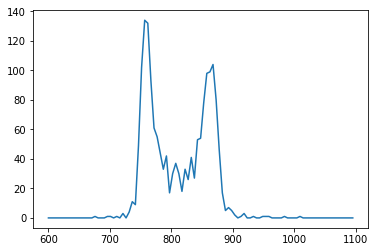

In [48]:
y=0
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()
y=1
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()
y=2
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()
y=3
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()
y=4
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()
y=5
plt.figure()
[plt.plot(lensd_photons[y][x][3][1][0:-1],lensd_photons[y][x][3][0]) for x in [0]]
plt.show()

In [34]:
[sum([lensd_photons[0][0][x] for x in [0,4,8,12,16]])

13326

In [37]:
[sum([lensd_photons[y][i][z] for z in [0,4,8,12,16]]) for i,x in enumerate(xpos)]

[13326, 14280, 14146, 14548, 14016, 13037, 12333, 11295, 10658, 7439]

In [16]:
vars(cuda.gpus[0])

{'_device': <weakproxy at 0x0000025C5E5C8958 to Device at 0x0000025C5E4E2198>}

In [31]:
cuda.list_devices().current

In [31]:
0.1/(sqrt(2*log(2)))

0.08493218002880192

1


TypeError: list indices must be integers or slices, not tuple

In [46]:
randomnrs= pcl.rand.normal(0.,1/sqrt(2),1000000,dtype=np.float32, device=False)
np.std(randomnrs)

0.70658433

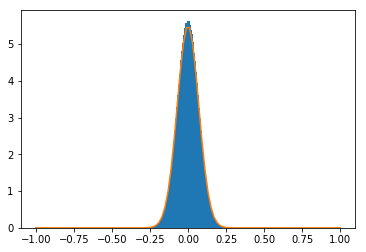

In [47]:
plt.figure()
plt.hist(randomnrs*0.1,100,density=True)
plt.plot(np.linspace(-1,1,100),[exp(-(x**2)/(0.1**2))*5.5 for x in np.linspace(-1,1,100)])
plt.show()

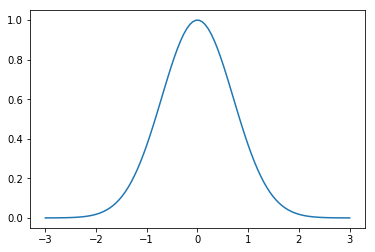

In [34]:
plt.figure()
plt.plot(np.linspace(-3,3,100),[exp(-(x**2)/(1**2)) for x in np.linspace(-3,3,100)])
plt.show()

In [77]:
[[2.5-22.8,2.5]]*5

[[-20.3, 2.5], [-20.3, 2.5], [-20.3, 2.5], [-20.3, 2.5], [-20.3, 2.5]]

In [43]:
import sys


In [44]:
sys.version

'3.6.3 |Anaconda, Inc.| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]'

In [238]:
Crystal1=Crystal(name = 'BBO1',material = 'BBO',position = [0,0,2.5],thickness = 5,orientation="up",cutangle=28.76*np.pi/180)
lenspos=25*4
ACH=Lens.asphere_r(position = [0,0,lenspos],centre=[-0.18,0,0],f=250)
Csetup=ExpSetup(Crystal1,ACH)
sim2=Simulation(rays=[0],setup=Csetup)
sim2.run(Ntot=90000000,nr_crystals=1,gen_SPDC = True,pumpray=Ray(position=[0,0,0],angles=[0,0],wavelength=405,polarization="H"),pump_waist=[0.1,0.005],pump_focus=[2.5,2.5],pump_M2=[1,1],walkoff=True,pumpcurv=True)
print(len(sim2.complete_results[0][0]))

331613


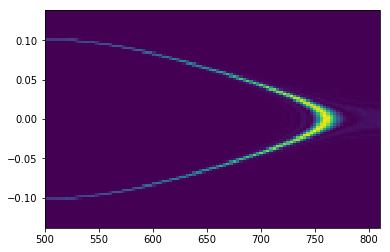

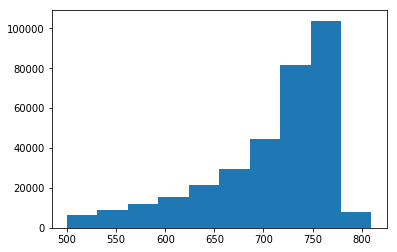

In [241]:
plt.figure()
plt.hist(start_photons[0][2].T[0])
plt.show()

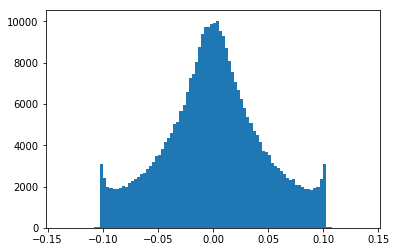

In [242]:
plt.figure()
plt.hist(np.sign((start_photons[0][1]-start_photons[1][1]).T[0])*np.linalg.norm(start_photons[0][1]-start_photons[1][1],axis=1),100)
plt.show()


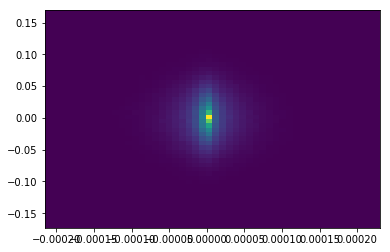

In [243]:
plt.figure()
plt.hist2d(((start_photons[0][1]+start_photons[1][1]).T)[0],((start_photons[0][1]+start_photons[1][1]).T)[1],50)

plt.show()


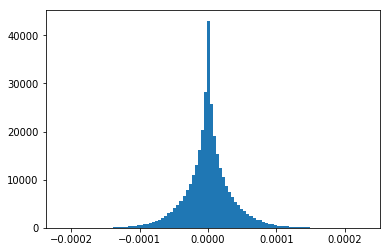

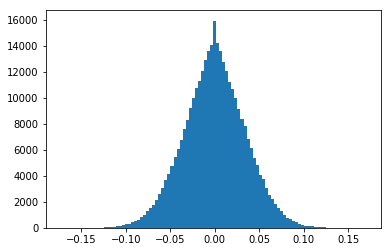

In [244]:
plt.figure()
plt.hist(((start_photons[0][1]+start_photons[1][1]).T)[0],100)
plt.show()

plt.figure()
plt.hist(((start_photons[0][1]+start_photons[1][1]).T)[1],100)
plt.show()

In [143]:
np.mean(((start_photons[0][1]+start_photons[1][1]).T)[0])

0.0046948625381986976